# Chapter 14 – Deep Computer Vision Using Convolutional Neural Networks**

_This notebook contains all the sample code in chapter 14._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/14_deep_computer_vision_with_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/14_deep_computer_vision_with_cnns.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12611312379413213804,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2911292622
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1756802220831436718
 physical_device_desc: "device: 0, name: Quadro P2000, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [4]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

A couple utility functions to plot grayscale and RGB images:

In [6]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

## What is a Convolution?

<img src="./chapters/14/14-3.png">
<div style="text-align:center"> Figure 14-3. Connections between layers and zero padding </div>

<img src="./chapters/14/14-4.png">
<div style="text-align:center"> Figure 14-4. Reducing dimensionality using a stride of 2 </div>

Input images are also composed of multiple sublayers: one per color channel. There are typically three: red, green, and blue (RGB). Grayscale images have just one channel, but some images may have much more—for example, satellite images that capture extra light frequencies (such as infrared).

<img src="./chapters/14/14-6.png">
<div style="text-align:center"> Figure 14-6. Convolutional layers with multiple feature maps, and images with three color channels </div>

In [7]:
import numpy as np
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
images.shape

(2, 427, 640, 3)

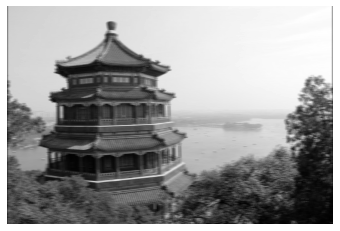

In [8]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32) # shape is (7,7,3,2) height, width, input-channel, output-channel
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME") 
# With "SAME" padding, if you use a stride of 1, the layer's outputs will have the same spatial dimensions as its inputs.

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

In [9]:
outputs.shape

TensorShape([2, 427, 640, 2])

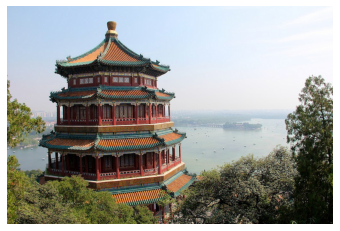

In [10]:
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
plt.imshow(images[0])
plt.axis("off") # Not shown in the book
plt.show()

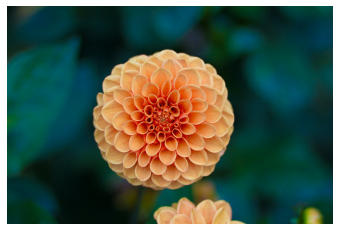

In [11]:
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
plt.imshow(images[1])
plt.axis("off") # Not shown in the book
plt.show()

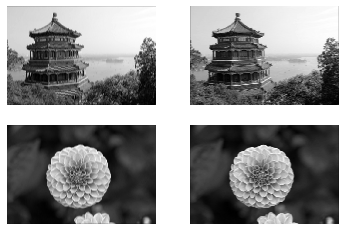

In [12]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [13]:
def crop(images):
    return images[150:220, 130:250]

Saving figure china_original


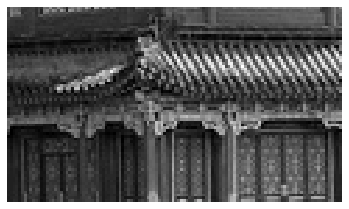

Saving figure china_vertical


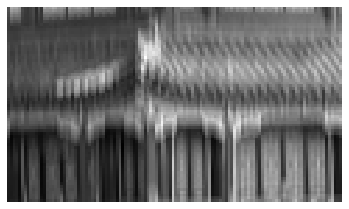

Saving figure china_horizontal


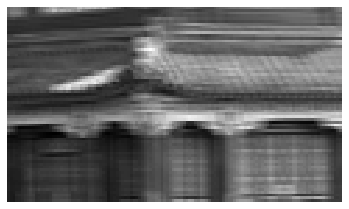

In [14]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

<img src="./chapters/14/14-5.png">
<div style="text-align:center"> Figure 14-5. Applying two different filters to get two feature maps </div>

Let’s go through this code:

- The pixel intensity for each color channel is represented as a byte from 0 to 255, so we scale these features simply by dividing by 255, to get floats ranging from 0 to 1.

- Then we create two `7 × 7` filters (one with a vertical white line in the middle, and the other with a horizontal white line in the middle).

- We apply them to both images using the `tf.nn.conv2d()` function, which is part of TensorFlow’s low-level Deep Learning API. In this example, we use zero padding (`padding="SAME"`) and a stride of 1.

- Finally, we plot one of the resulting feature maps (similar to the top-right image in Figure 14-5).

The `tf.nn.conv2d()` line deserves a bit more explanation:

- images is the input mini-batch (a 4D tensor, as explained earlier).

- filters is the set of filters to apply (also a 4D tensor, as explained earlier).

- strides is equal to 1, but it could also be a 1D array with four elements, where the two central elements are the vertical and horizontal strides (sh and sw). The first and last elements must currently be equal to 1. They may one day be used to specify a batch stride (to skip some instances) and a channel stride (to skip some of the previous layer’s feature maps or channels).

- padding must be either `"SAME"` or `"VALID"`:

  - If set to `"SAME"`, the convolutional layer uses zero padding if necessary. The output size is set to the number of input neurons divided by the stride, rounded up. For example, if the input size is 13 and the stride is 5 (see Figure 14-7), then the output size is 3 (i.e., 13 / 5 = 2.6, rounded up to 3). Then zeros are added as evenly as possible around the inputs, as needed. When strides=1, the layer’s outputs will have the same spatial dimensions (width and height) as its inputs, hence the name same.

  - If set to `"VALID"`, the convolutional layer does not use zero padding and may ignore some rows and columns at the bottom and right of the input image, depending on the stride, as shown in Figure 14-7 (for simplicity, only the horizontal dimension is shown here, but of course the same logic applies to the vertical dimension). This means that every neuron’s receptive field lies strictly within valid positions inside the input (it does not go out of bounds), hence the name valid.

<img src="./chapters/14/14-7.png">
<div style="text-align:center"> Figure 14-7. Padding="SAME” or “VALID” (with input width 13, filter width 6, stride 5) </div>

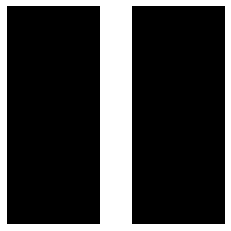

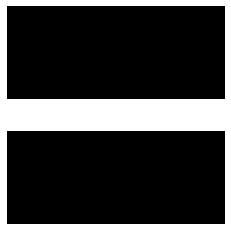

In [15]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

## Convolutional Layer

Let's create a 2D convolutional layer, using `keras.layers.Conv2D()`:

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1,
                           padding="SAME", activation="relu", 
                           input_shape=outputs.shape)

Let's call this layer, passing it the two test images:

In [17]:
conv_outputs = conv(images)
conv_outputs.shape 

TensorShape([2, 427, 640, 2])

The output is a 4D tensor. The dimensions are: batch size, height, width, channels. The first dimension (batch size) is 2 since there are 2 input images. The next two dimensions are the height and width of the output feature maps: since `padding="SAME"` and `strides=1`, the output feature maps have the same height and width as the input images (in this case, 427×640). Lastly, this convolutional layer has 2 filters, so the last dimension is 2: there are 2 output feature maps per input image.

Since the filters are initialized randomly, they'll initially detect random patterns. Let's take a look at the 2 output features maps for each image:

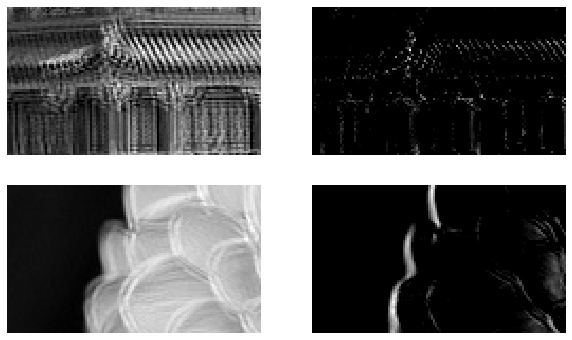

In [18]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

Although the filters were initialized randomly, the second filter happens to act like an edge detector. Randomly initialized filters often act this way, which is quite fortunate since detecting edges is quite useful in image processing.

If we want, we can set the filters to be the ones we manually defined earlier, and set the biases to zeros (in real life we will almost never need to set filters or biases manually, as the convolutional layer will just learn the appropriate filters and biases during training):

In [19]:
conv.set_weights([filters, np.zeros(2)])

Now let's call this layer again on the same two images, and let's check that the output feature maps do highlight vertical lines and horizontal lines, respectively (as earlier):

In [20]:
conv_outputs = conv(images)
conv_outputs.shape 

TensorShape([2, 427, 640, 2])

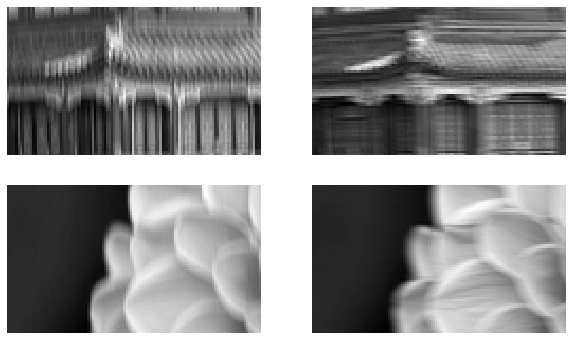

In [21]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

## VALID vs SAME padding

In [22]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [23]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [24]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

Using `"SAME"` padding is equivalent to padding manually using `manual_same_padding()` then using `"VALID"` padding (confusingly, `"VALID"` padding means no padding at all):

In [25]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Need to call build() so conv_same's weights get created
conv_same.build(tf.TensorShape(images.shape))

# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

# Pooling layer

## Max pooling

In [26]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [27]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

Saving figure china_max_pooling


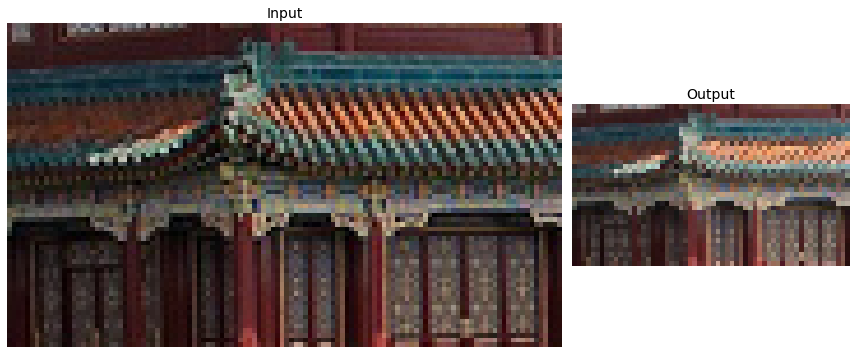

In [28]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

## Depth-wise pooling

In [29]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [30]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

Or just use a `Lambda` layer:

In [31]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

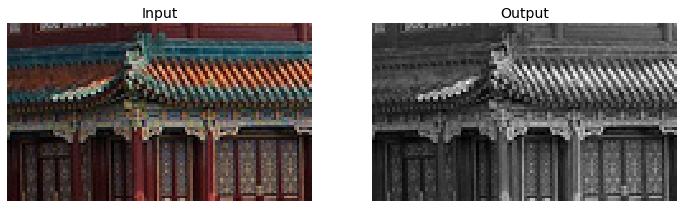

In [32]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

## Average pooling

In [33]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [34]:
output_avg = avg_pool(cropped_images)

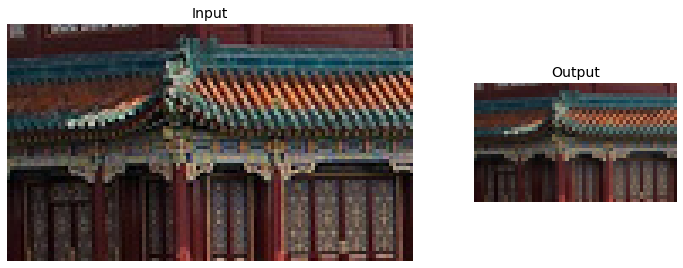

In [35]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

## Global Average Pooling

In [36]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.45952484, 0.3342377 ]], dtype=float32)>

In [37]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.45952484, 0.3342377 ]], dtype=float32)>

# Tackling Fashion MNIST With a CNN

In [38]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [39]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [40]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 156s 90ms/step - loss: 0.7142 - accuracy: 0.7497 - val_loss: 0.3750 - val_accuracy: 0.8618
Epoch 2/10
1719/1719 [==============================] - 152s 89ms/step - loss: 0.4243 - accuracy: 0.8573 - val_loss: 0.3645 - val_accuracy: 0.8748
Epoch 3/10
1719/1719 [==============================] - 153s 89ms/step - loss: 0.3755 - accuracy: 0.8736 - val_loss: 0.3277 - val_accuracy: 0.8836
Epoch 4/10
1719/1719 [==============================] - 152s 88ms/step - loss: 0.3327 - accuracy: 0.8881 - val_loss: 0.2929 - val_accuracy: 0.8886
Epoch 5/10
1719/1719 [==============================] - 153s 89ms/step - loss: 0.3110 - accuracy: 0.8924 - val_loss: 0.2870 - val_accuracy: 0.8996
Epoch 6/10
1719/1719 [==============================] - 152s 88ms/step - loss: 0.2918 - accuracy: 0.9013 - val_loss: 0.2950 - val_accuracy: 0.8882
Epoch 7/10
1719/1719 [==============================] - 157s 91ms/step - loss: 0.2754 - accuracy: 0.9042 - val_loss: 0

Let’s go through this model:

- The first layer uses 64 fairly large filters (7 × 7) but no stride because the input images are not very large. It also sets input_shape=[28, 28, 1], because the images are 28 × 28 pixels, with a single color channel (i.e., grayscale).

- Next we have a max pooling layer which uses a pool size of 2, so it divides each spatial dimension by a factor of 2.

- Then we repeat the same structure twice: two convolutional layers followed by a max pooling layer. For larger images, we could repeat this structure several more times (the number of repetitions is a hyperparameter you can tune).

- Note that the number of filters grows as we climb up the CNN toward the output layer (it is initially 64, then 128, then 256): it makes sense for it to grow, since the number of low-level features is often fairly low (e.g., small circles, horizontal lines), but there are many different ways to combine them into higher-level features. It is a common practice to double the number of filters after each pooling layer: since a pooling layer divides each spatial dimension by a factor of 2, we can afford to double the number of feature maps in the next layer without fear of exploding the number of parameters, memory usage, or computational load.

- Next is the fully connected network, composed of two hidden dense layers and a dense output layer. Note that we must flatten its inputs, since a dense network expects a 1D array of features for each instance. We also add two dropout layers, with a dropout rate of 50% each, to reduce overfitting.

[batch normalization params](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739#:~:text=Just%20like%20the%20parameters%20(eg,of%20the%20Batch%20Norm%20layer.)

Just like the parameters (eg. weights, bias) of any network layer, a Batch Norm layer also has parameters of its own:

- Two learnable parameters called beta and gamma.
- Two non-learnable parameters (Mean Moving Average and Variance Moving Average) are saved as part of the ‘state’ of the Batch Norm layer.
<img src="./chapters/14/14-a.png">

These parameters are per Batch Norm layer. So if we have, say, three hidden layers and three Batch Norm layers in the network, we would have three learnable beta and gamma parameters for the three layers. Similarly for the Moving Average parameters.

<img src="./chapters/14/14-b.png">
During training, we feed the network one mini-batch of data at a time. During the forward pass, each layer of the network processes that mini-batch of data. The Batch Norm layer processes its data as follows:
<img src="./chapters/14/14-c.png">

- #### 1. Activations
The activations from the previous layer are passed as input to the Batch Norm. There is one activation vector for each feature in the data.

- #### 2. Calculate Mean and Variance
For each activation vector separately, calculate the mean and variance of all the values in the mini-batch.

- #### 3. Normalize
Calculate the normalized values for each activation feature vector using the corresponding mean and variance. These normalized values now have zero mean and unit variance.

- #### 4. Scale and Shift
This step is the huge innovation introduced by Batch Norm that gives it its power. Unlike the input layer, which requires all normalized values to have zero mean and unit variance, Batch Norm allows its values to be shifted (to a different mean) and scaled (to a different variance). It does this by multiplying the normalized values by a factor, gamma, and adding to it a factor, beta. Note that this is an element-wise multiply, not a matrix multiply.

    What makes this innovation ingenious is that these factors are not hyperparameters (ie. constants provided by the model designer) but are trainable parameters that are learned by the network. In other words, each Batch Norm layer is able to optimally find the best factors for itself, and can thus shift and scale the normalized values to get the best predictions.

- #### 5. Moving Average
In addition, Batch Norm also keeps a running count of the Exponential Moving Average (EMA) of the mean and variance. During training, it simply calculates this EMA but does not do anything with it. At the end of training, it simply saves this value as part of the layer’s state, for use during the Inference phase.

    We will return to this point a little later when we talk about Inference. The Moving Average calculation uses a scalar ‘momentum’ denoted by alpha below. This is a hyperparameter that is used only for Batch Norm moving averages and should not be confused with the momentum that is used in the Optimizer.
    
#### Vector Shapes
Below, we can see the shapes of these vectors. The values that are involved in computing the vectors for a particular feature are also highlighted in red. However, remember that all feature vectors are computed in a single matrix operation.
<img src="./chapters/14/14-d.png">


After the forward pass, we do the backward pass as normal. Gradients are calculated and updates are done for all layer weights, as well as for all beta and gamma parameters in the Batch Norm layers.

#### Batch Norm during Inference
As we discussed above, during Training, Batch Norm starts by calculating the mean and variance for a mini-batch. However, during Inference, we have a single sample, not a mini-batch. How do we obtain the mean and variance in that case?

Here is where the two Moving Average parameters come in — the ones that we calculated during training and saved with the model. We use those saved mean and variance values for the Batch Norm during Inference.  

<img src="./chapters/14/14-e.png">

Ideally, during training, we could have calculated and saved the mean and variance for the full data. But that would be very expensive as we would have to keep values for the full dataset in memory during training. Instead, the Moving Average acts as a good proxy for the mean and variance of the data. It is much more efficient because the calculation is incremental — we have to remember only the most recent Moving Average.


## ResNet-34

When training a neural network, the goal is to make it model a target function $h(x)$. If you add the input $x$ to the output of the network (i.e., you add a skip connection), then the network will be forced to model $f(x) = h(x) - x$ rather than $h(x)$. This is called residual learning (see Figure 14-15).

<img src="./chapters/14/14-15.png">
<div style="text-align:center"> Figure 14-15. Residual learning </div>

Moreover, if you add many skip connections, the network can start making progress even if several layers have not started learning yet (see Figure 14-16). Thanks to skip connections, the signal can easily make its way across the whole network. The deep residual network can be seen as a stack of residual units (RUs), where each residual unit is a small neural network with a skip connection.

<img src="./chapters/14/14-16.png">
<div style="text-align:center"> Figure 14-16. Regular deep neural network (left) and deep residual network (right) </div>

Now let’s look at ResNet’s architecture (see Figure 14-17). It is surprisingly simple. It starts and ends exactly like GoogLeNet (except without a dropout layer), and in between is just a very deep stack of simple residual units. Each residual unit is composed of two convolutional layers (and no pooling layer!), with Batch Normalization (BN) and ReLU activation, using 3 × 3 kernels and preserving spatial dimensions (stride `1`, `"same"` padding).

<img src="./chapters/14/14-17.png">
<div style="text-align:center"> Figure 14-17. ResNet architecture </div>

Note that the number of feature maps is doubled every few residual units, at the same time as their height and width are halved (using a convolutional layer with stride 2). When this happens, the inputs cannot be added directly to the outputs of the residual unit because they don’t have the same shape (for example, this problem affects the skip connection represented by the dashed arrow in Figure 14-17). To solve this problem, the inputs are passed through a 1 × 1 convolutional layer with stride 2 and the right number of output feature maps (see Figure 14-18).

<img src="./chapters/14/14-18.png">
<div style="text-align:center"> Figure 14-18. Skip connection when changing feature map size and depth </div>

ResNet-34 is the ResNet with 34 layers (only counting the convolutional layers and the fully connected layer) containing 3 residual units that output 64 feature maps, 4 RUs with 128 maps, 6 RUs with 256 maps, and 3 RUs with 512 maps. We will implement this architecture later in this chapter.

ResNets deeper than that, such as ResNet-152, use slightly different residual units. Instead of two 3 × 3 convolutional layers with, say, 256 feature maps, they use three convolutional layers: first a 1 × 1 convolutional layer with just 64 feature maps (4 times less), which acts as a bottleneck layer (as discussed already), then a 3 × 3 layer with 64 feature maps, and finally another 1 × 1 convolutional layer with 256 feature maps (4 times 64) that restores the original depth. ResNet-152 contains 3 such RUs that output 256 maps, then 8 RUs with 512 maps, a whopping 36 RUs with 1,024 maps, and finally 3 RUs with 2,048 maps.

## Implementing a ResNet-34 CNN Using Keras

In [2]:
options = [1,2,3]
def func(first=None, second=None, last=None):
    print("first arg:", first)
    print("second arg:", second)
    print("third arg:", last)

func(*options), func(options)

first arg: 1
second arg: 2
third arg: 3
first arg: [1, 2, 3]
second arg: None
third arg: None


(None, None)

In [41]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs): 
        #__init__(**kwargs): packs all of the keyword arguments used in any given call to __init__ into a dict
        super().__init__(**kwargs) # expands them into keyword arguments again.
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(), #BatchNormalization before activation
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [5]:
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    print(filters)
3+4+6+3

64
64
64
128
128
128
128
256
256
256
256
256
256
512
512
512


16

In [42]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)       

In [8]:
#conv2d_8 and batch_normalization
#use_bias=False because the batch_normalization layer
(7*7*3)*64, 64*4 # BatchNormalization layer has 64*4=256 parameters, (gamma, beta, mu_mov, sigma_mov) for each output filter

(9408, 256)

In [13]:
#residual_unit 0-2
(3*3*64)*64+64*4+(3*3*64)*64+64*4

74240

In [15]:
#residual_unit 3
(3*3*64)*128+128*4+(3*3*128)*128+128*4+(1*1*64)*128+128*4

230912

In [16]:
#residual_unit 4-6
(3*3*128)*128+128*4+(3*3*128)*128+128*4

295936

In [18]:
#residual_unit 7
(3*3*128)*256+256*4+(3*3*256)*256+256*4+(1*1*128)*256+256*4

920576

In [19]:
#residual_unit 8-12
(3*3*256)*256+256*4+(3*3*256)*256+256*4

1181696

In [20]:
#residual_unit 13
(3*3*256)*512+512*4+(3*3*512)*512+512*4+(1*1*256)*512+512*4

3676160

In [21]:
#residual_unit 14-15
(3*3*512)*512+512*4+(3*3*512)*512+512*4

4722688

In [23]:
#dense_3 
#use_bias=True
(512+1)*10

5130

## Using a Pretrained Model

In [44]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

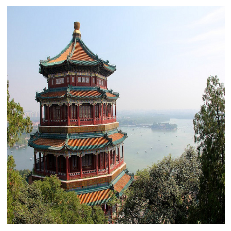

In [45]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


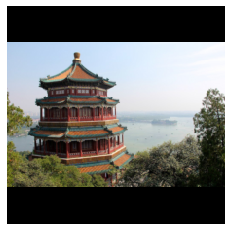

In [46]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

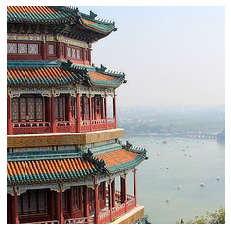

In [47]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

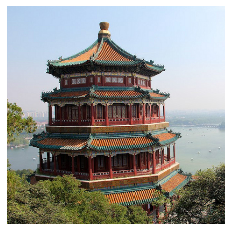

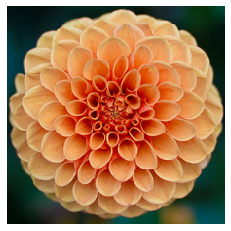

In [48]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [49]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [50]:
Y_proba.shape

(2, 1000)

In [51]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.08%
  n03781244 - monastery    11.69%

Image #1
  n04522168 - vase         53.97%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.96%



## Pretrained Models for Transfer Learning 

If you want to build an image classifier but you do not have enough training data, then it is often a good idea to reuse the lower layers of a pretrained model, as we discussed in Chapter 11. For example, let’s train a model to classify pictures of flowers, reusing a pretrained Xception model. First, let’s load the dataset using TensorFlow Datasets (see Chapter 13):

In [6]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

In [53]:
info.splits

{'train': <SplitInfo num_examples=3670, num_shards=2>}

In [54]:
info.splits["train"]

<SplitInfo num_examples=3670, num_shards=2>

In [7]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [8]:
n_classes = info.features["label"].num_classes # 5

In [9]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

Note that you can get information about the dataset by setting `with_info=True`. Here, we get the dataset size and the names of the classes. Unfortunately, there is only a "train" dataset, no test set or validation set, so we need to split the training set. The TF Datasets project provides an API for this. For example, let’s take the first 10% of the dataset for testing, the next 15% for validation, and the remaining 75% for training:

In [10]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

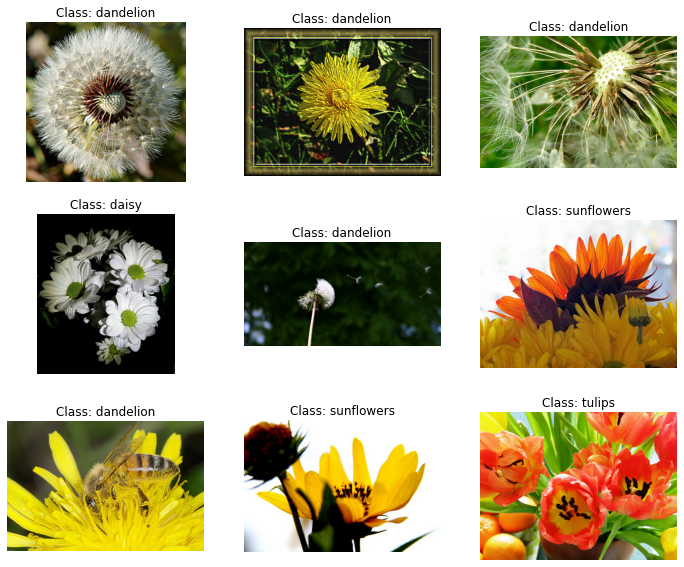

In [11]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

Next we must preprocess the images. The CNN expects `224 × 224` images, so we need to resize them. We also need to run the images through Xception’s `preprocess_input()` function:

Basic preprocessing:

In [12]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

Slightly fancier preprocessing (but you could add much more data augmentation):

If you want to perform some data augmentation, change the preprocessing function for the training set, adding some random transformations to the training images. For example, use `tf.image.random_crop()` to randomly crop the images, use `tf.image.random_flip_left_right()` to randomly flip the images horizontally, and so on (see the “Pretrained Models for Transfer Learning” section of the notebook for an example).

In [14]:
from functools import partial
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

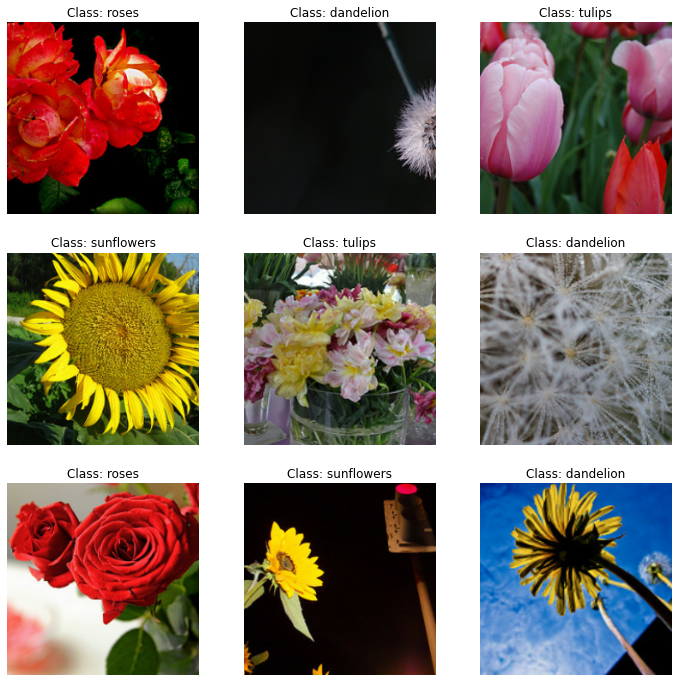

In [15]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

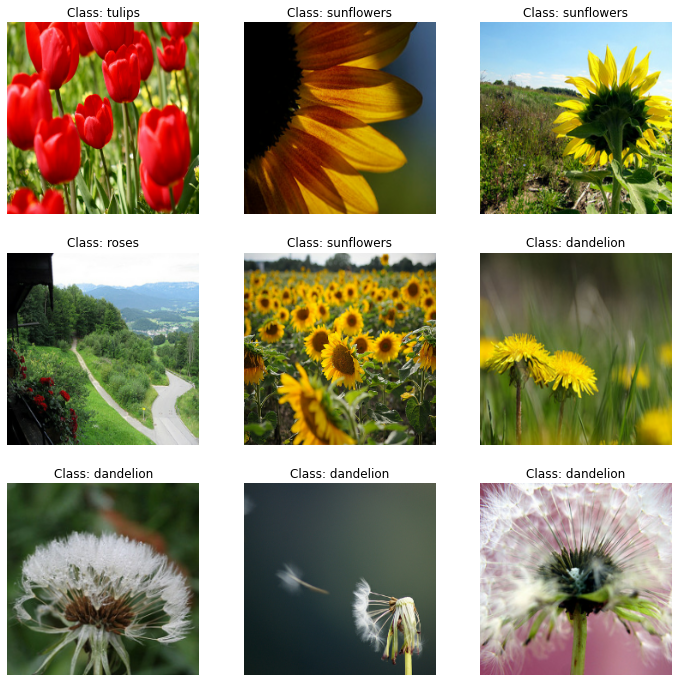

In [16]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

Next let’s load an Xception model, pretrained on ImageNet. We exclude the top of the network by setting `include_top=False`: this excludes the global average pooling layer and the dense output layer. We then add our own global average pooling layer, based on the output of the base model, followed by a dense output layer with one unit per class, using the `softmax` activation function. Finally, we create the Keras `Model`:

In [17]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [18]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [66]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 139s 2s/step - loss: 1.4720 - accuracy: 0.7925 - val_loss: 1.4752 - val_accuracy: 0.8070
Epoch 2/5
86/86 [==============================] - 141s 2s/step - loss: 0.6576 - accuracy: 0.8914 - val_loss: 0.9815 - val_accuracy: 0.8732
Epoch 3/5
86/86 [==============================] - 142s 2s/step - loss: 0.3623 - accuracy: 0.9248 - val_loss: 0.8554 - val_accuracy: 0.8732
Epoch 4/5
86/86 [==============================] - 142s 2s/step - loss: 0.2582 - accuracy: 0.9335 - val_loss: 0.7072 - val_accuracy: 0.8842
Epoch 5/5
86/86 [==============================] - 140s 2s/step - loss: 0.2029 - accuracy: 0.9440 - val_loss: 0.7266 - val_accuracy: 0.8732


After training the model for a few epochs, its validation accuracy should reach about 75–80% and stop making much progress. This means that the top layers are now pretty well trained, so we are ready to unfreeze all the layers (or you could try unfreezing just the top ones) and continue training (don’t forget to compile the model when you freeze or unfreeze layers). This time we use a much lower learning rate to avoid damaging the pretrained weights:

In [67]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=10)

Epoch 1/10
86/86 [==============================] - 1062s 12s/step - loss: 0.3514 - accuracy: 0.8866 - val_loss: 0.5538 - val_accuracy: 0.8438
Epoch 2/10
86/86 [==============================] - 1027s 12s/step - loss: 0.1213 - accuracy: 0.9644 - val_loss: 0.3166 - val_accuracy: 0.8915
Epoch 3/10
86/86 [==============================] - 1010s 12s/step - loss: 0.0683 - accuracy: 0.9789 - val_loss: 0.3020 - val_accuracy: 0.9062
Epoch 4/10
86/86 [==============================] - 1000s 12s/step - loss: 0.0600 - accuracy: 0.9844 - val_loss: 0.3095 - val_accuracy: 0.9081
Epoch 5/10
86/86 [==============================] - 1015s 12s/step - loss: 0.0277 - accuracy: 0.9880 - val_loss: 0.3197 - val_accuracy: 0.9136
Epoch 6/10
86/86 [==============================] - 1004s 12s/step - loss: 0.0206 - accuracy: 0.9927 - val_loss: 0.3108 - val_accuracy: 0.9191
Epoch 7/10
86/86 [==============================] - 1014s 12s/step - loss: 0.0171 - accuracy: 0.9942 - val_loss: 0.2959 - val_accuracy: 0.9228

# Classification and Localization 

Localizing an object in a picture can be expressed as a regression task, as discussed in Chapter 10: to predict a bounding box around the object, a common approach is to predict the horizontal and vertical coordinates of the object’s center, as well as its height and width. This means we have four numbers to predict. It does not require much change to the model; we just need to add a second dense output layer with four units (typically on top of the global average pooling layer), and it can be trained using the MSE loss:

In [20]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)

avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])



Let’s suppose you’ve obtained the bounding boxes for every image in the flowers dataset (for now we will assume there is a single bounding box per image). You then need to create a dataset whose items will be batches of preprocessed images along with their class labels and their bounding boxes. Each item should be a tuple of the form `(images, (class_labels, bounding_boxes))`. Then you are ready to train your model! 

The MSE often works fairly well as a cost function to train the model, but it is not a great metric to evaluate how well the model can predict bounding boxes. The most common metric for this is the Intersection over Union (IoU): the area of overlap between the predicted bounding box and the target bounding box, divided by the area of their union (see Figure 14-23). In `tf.keras`, it is implemented by the `tf.keras.metrics.MeanIoU` class.


<img src="./chapters/14/14-23.png">
<div style="text-align:center"> Figure 14-23. Intersection over Union (IoU) metric for bounding boxes </div>

In [40]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

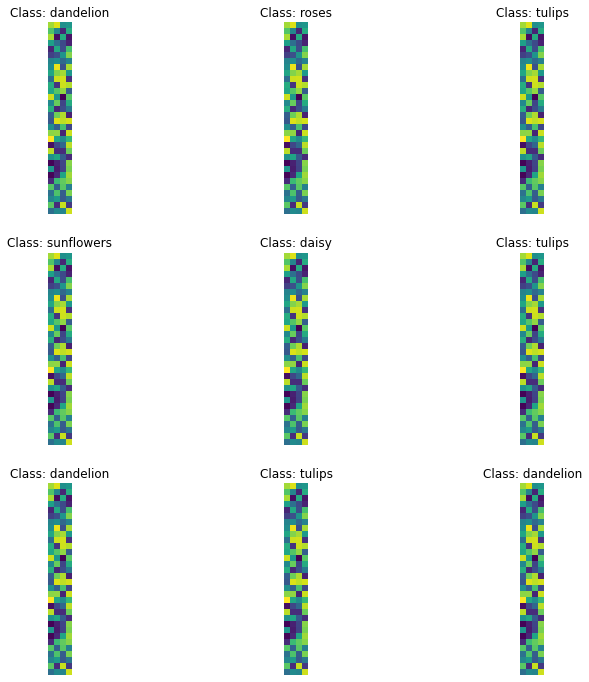

In [41]:
plt.figure(figsize=(12, 12))
for X_batch, (y_batch, fake_bboxes) in fake_train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.imshow(fake_bboxes / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

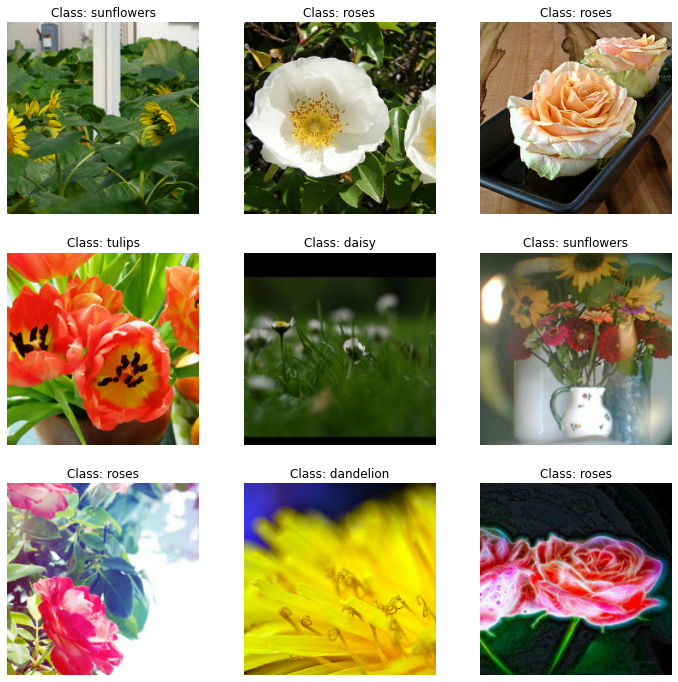

In [42]:
plt.figure(figsize=(12, 12))
for X_batch, (y_batch, fake_bboxes) in fake_train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        #plt.imshow(fake_bboxes / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [70]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Epoch 1/2
5/5 [==============================] - 63s 12s/step - loss: 1.3657 - dense_5_loss: 1.6123 - dense_6_loss: 0.3792 - dense_5_accuracy: 0.1937 - dense_6_accuracy: 0.1937
Epoch 2/2
5/5 [==============================] - 61s 12s/step - loss: 1.2689 - dense_5_loss: 1.5198 - dense_6_loss: 0.2651 - dense_5_accuracy: 0.3562 - dense_6_accuracy: 0.2875


## Mean Average Precision (mAP)

In [71]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

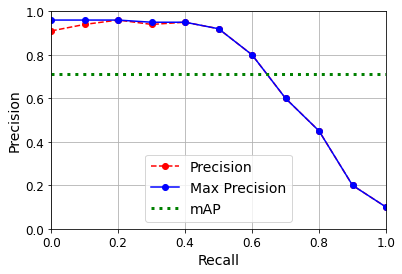

In [72]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center", fontsize=14)
plt.show()

Transpose convolutions:

In [73]:
tf.random.set_seed(42)
X = images_resized.numpy()

conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3, strides=2, padding="VALID")
output = conv_transpose(X)
output.shape

TensorShape([2, 449, 449, 5])

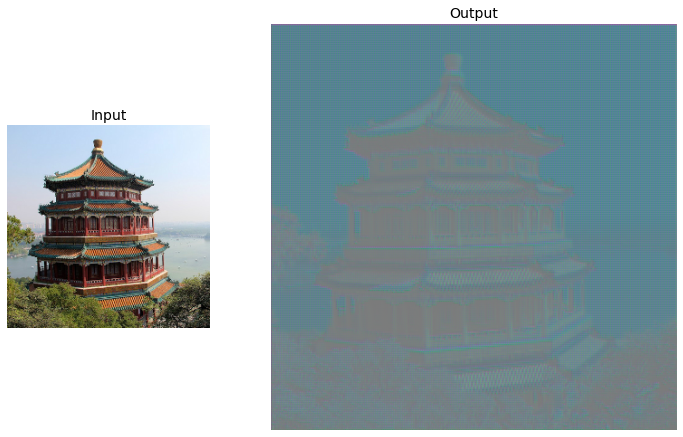

In [74]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(normalize(output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax2.axis("off")
plt.show()

In [75]:
def upscale_images(images, stride, kernel_size):
    batch_size, height, width, channels = images.shape
    upscaled = np.zeros((batch_size,
                         (height - 1) * stride + 2 * kernel_size - 1,
                         (width - 1) * stride + 2 * kernel_size - 1,
                         channels))
    upscaled[:,
             kernel_size - 1:(height - 1) * stride + kernel_size:stride,
             kernel_size - 1:(width - 1) * stride + kernel_size:stride,
             :] = images
    return upscaled

In [76]:
upscaled = upscale_images(X, stride=2, kernel_size=3)
weights, biases = conv_transpose.weights
reversed_filters = np.flip(weights.numpy(), axis=[0, 1])
reversed_filters = np.transpose(reversed_filters, [0, 1, 3, 2])
manual_output = tf.nn.conv2d(upscaled, reversed_filters, strides=1, padding="VALID")

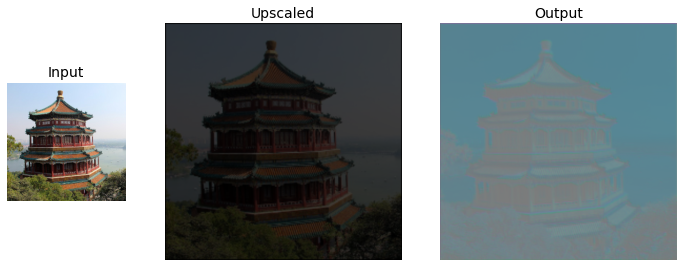

In [77]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 2, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Upscaled", fontsize=14)
ax2.imshow(upscaled[0], interpolation="bicubic")
ax2.axis("off")
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title("Output", fontsize=14)
ax3.imshow(normalize(manual_output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax3.axis("off")
plt.show()

In [78]:
np.allclose(output, manual_output.numpy(), atol=1e-7)

True

# Exercises

#### 1. What are the advantages of a CNN over a fully connected DNN for image classification? 

- Because consecutive layers are only partially connected and because it heavily reuses its weights, a CNN has many fewer parameters than a fully connected DNN, which makes it much faster to train, reduces the risk of overfitting, and requires much less training data.

- When a CNN has learned a kernel that can detect a particular feature, it can detect that feature anywhere in the image. In contrast, when a DNN learns a feature in one location, it can detect it only in that particular location. Since images typically have very repetitive features, CNNs are able to generalize much better than DNNs for image processing tasks such as classification, using fewer training examples.

- Finally, a DNN has no prior knowledge of how pixels are organized; it does not know that nearby pixels are close. A CNN’s architecture embeds this prior knowledge. Lower layers typically identify features in small areas of the images, while higher layers combine the lower-level features into larger features. This works well with most natural images, giving CNNs a decisive head start compared to DNNs.

#### 2. Consider a CNN composed of three convolutional layers, each with 3 × 3 kernels, a stride of 2, and "same" padding. The lowest layer outputs 100 feature maps, the middle one outputs 200, and the top one outputs 400. The input images are RGB images of 200 × 300 pixels. What is the total number of parameters in the CNN? If we are using 32-bit floats, at least how much RAM will this network require when making a prediction for a single instance? What about when training on a mini-batch of 50 images?

Let’s compute how many parameters the CNN has. Since its first convolutional layer has 3 × 3 kernels, and the input has three channels (red, green, and blue), each feature map has 3 × 3 × 3 weights, plus a bias term. That’s 28 parameters per feature map. Since this first convolutional layer has 100 feature maps, it has a total of 2,800 parameters. The second convolutional layer has 3 × 3 kernels and its input is the set of 100 feature maps of the previous layer, so each feature map has 3 × 3 × 100 = 900 weights, plus a bias term. Since it has 200 feature maps, this layer has 901 × 200 = 180,200 parameters. Finally, the third and last convolutional layer also has 3 × 3 kernels, and its input is the set of 200 feature maps of the previous layers, so each feature map has 3 × 3 × 200 = 1,800 weights, plus a bias term. Since it has 400 feature maps, this layer has a total of 1,801 × 400 = 720,400 parameters. All in all, the CNN has 2,800 + 180,200 + 720,400 = 903,400 parameters.

Now let’s compute how much RAM this neural network will require (at least) when making a prediction for a single instance. First let’s compute the feature map size for each layer. Since we are using a stride of 2 and "same" padding, the horizontal and vertical dimensions of the feature maps are divided by 2 at each layer (rounding up if necessary). So, as the input channels are 200 × 300 pixels, the first layer’s feature maps are 100 × 150, the second layer’s feature maps are 50 × 75, and the third layer’s feature maps are 25 × 38. Since 32 bits is 4 bytes and the first convolutional layer has 100 feature maps, this first layer takes up 4 × 100 × 150 × 100 = 6 million bytes (6 MB). The second layer takes up 4 × 50 × 75 × 200 = 3 million bytes (3 MB). Finally, the third layer takes up 4 × 25 × 38 × 400 = 1,520,000 bytes (about 1.5 MB). However, once a layer has been computed, the memory occupied by the previous layer can be released, so if everything is well optimized, only 6 + 3 = 9 million bytes (9 MB) of RAM will be required (when the second layer has just been computed, but the memory occupied by the first layer has not been released yet). But wait, you also need to add the memory occupied by the CNN’s parameters! We computed earlier that it has 903,400 parameters, each using up 4 bytes, so this adds 3,613,600 bytes (about 3.6 MB). The total RAM required is therefore (at least) 12,613,600 bytes (about 12.6 MB).

Lastly, let’s compute the minimum amount of RAM required when training the CNN on a mini-batch of 50 images. During training TensorFlow uses backpropagation, which requires keeping all values computed during the forward pass until the reverse pass begins. So we must compute the total RAM required by all layers for a single instance and multiply that by 50. At this point, let’s start counting in megabytes rather than bytes. We computed before that the three layers require respectively 6, 3, and 1.5 MB for each instance. That’s a total of 10.5 MB per instance, so for 50 instances the total RAM required is 525 MB. Add to that the RAM required by the input images, which is 50 × 4 × 200 × 300 × 3 = 36 million bytes (36 MB), plus the RAM required for the model parameters, which is about 3.6 MB (computed earlier), plus some RAM for the gradients (we will neglect this since it can be released gradually as backpropagation goes down the layers during the reverse pass). We are up to a total of roughly 525 + 36 + 3.6 = 564.6 MB, and that’s really an optimistic bare minimum.



#### 3. If your GPU runs out of memory while training a CNN, what are five things you could try to solve the problem?

If your GPU runs out of memory while training a CNN, here are five things you could try to solve the problem (other than purchasing a GPU with more RAM):

- Reduce the mini-batch size.

- Reduce dimensionality using a larger stride in one or more layers.

- Remove one or more layers.

- Use 16-bit floats instead of 32-bit floats.

- Distribute the CNN across multiple devices.


#### 4. Why would you want to add a max pooling layer rather than a convolutional layer with the same stride? 

A max pooling layer has no parameters at all, whereas a convolutional layer has quite a few (see the previous questions).

#### 5. When would you want to add a local response normalization layer? 

A local response normalization layer makes the neurons that most strongly activate inhibit neurons at the same location but in neighboring feature maps, which encourages different feature maps to specialize and pushes them apart, forcing them to explore a wider range of features. It is typically used in the lower layers to have a larger pool of low-level features that the upper layers can build upon.

#### 6. Can you name the main innovations in AlexNet, compared to LeNet-5? What about the main innovations in GoogLeNet, ResNet, SENet, and Xception?

The main innovations in AlexNet compared to LeNet-5 are that it is much larger and deeper, and it stacks convolutional layers directly on top of each other, instead of stacking a pooling layer on top of each convolutional layer. The main innovation in GoogLeNet is the introduction of inception modules, which make it possible to have a much deeper net than previous CNN architectures, with fewer parameters. ResNet’s main innovation is the introduction of skip connections, which make it possible to go well beyond 100 layers. Arguably, its simplicity and consistency are also rather innovative. SENet’s main innovation was the idea of using an SE block (a two-layer dense network) after every inception module in an inception network or every residual unit in a ResNet to recalibrate the relative importance of feature maps. Finally, Xception’s main innovation was the use of depthwise separable convolutional layers, which look at spatial patterns and depthwise patterns separately.



#### 7. What is a fully convolutional network? How can you convert a dense layer into a convolutional layer?  

Fully convolutional networks are neural networks composed exclusively of convolutional and pooling layers. FCNs can efficiently process images of any width and height (at least above the minimum size). They are most useful for object detection and semantic segmentation because they only need to look at the image once (instead of having to run a CNN multiple times on different parts of the image). If you have a CNN with some dense layers on top, you can convert these dense layers to convolutional layers to create an FCN: just replace the lowest dense layer with a convolutional layer with a kernel size equal to the layer’s input size, with one filter per neuron in the dense layer, and using "`valid`" padding. Generally the stride should be 1, but you can set it to a higher value if you want. The activation function should be the same as the dense layer’s. The other dense layers should be converted the same way, but using 1 × 1 filters. It is actually possible to convert a trained CNN this way by appropriately reshaping the dense layers’ weight matrices.

#### 8. What is the main technical difficulty of semantic segmentation?  

The main technical difficulty of semantic segmentation is the fact that a lot of the spatial information gets lost in a CNN as the signal flows through each layer, especially in pooling layers and layers with a stride greater than 1. This spatial information needs to be restored somehow to accurately predict the class of each pixel.

#### 9. Build your own CNN from scratch and try to achieve the highest possible accuracy on MNIST.


The following model uses 2 convolutional layers, followed by 1 pooling layer, then dropout 25%, then a dense layer, another dropout layer but with 50% dropout, and finally the output layer. It reaches about 99.2% accuracy on the test set. This places this model roughly in the top 20% in the [MNIST Kaggle competition](https://www.kaggle.com/c/digit-recognizer/) (if we ignore the models with an accuracy greater than 99.79% which were most likely trained on the test set, as explained by Chris Deotte in [this post](https://www.kaggle.com/c/digit-recognizer/discussion/61480)). Can you do better? To reach 99.5 to 99.7% accuracy on the test set, you need to add image augmentation, batch norm, use a learning schedule such as 1-cycle, and possibly create an ensemble.

In [79]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

11501568/11490434 [==============================] - 0s 0us/step


In [80]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Epoch 1/10
1719/1719 [==============================] - 173s 100ms/step - loss: 0.1963 - accuracy: 0.9403 - val_loss: 0.0463 - val_accuracy: 0.9874
Epoch 2/10
1719/1719 [==============================] - 163s 95ms/step - loss: 0.0798 - accuracy: 0.9756 - val_loss: 0.0425 - val_accuracy: 0.9880
Epoch 3/10
1719/1719 [==============================] - 162s 94ms/step - loss: 0.0610 - accuracy: 0.9807 - val_loss: 0.0335 - val_accuracy: 0.9916
Epoch 4/10
1719/1719 [==============================] - 162s 94ms/step - loss: 0.0511 - accuracy: 0.9840 - val_loss: 0.0294 - val_accuracy: 0.9920
Epoch 5/10
1719/1719 [==============================] - 161s 94ms/step - loss: 0.0399 - accuracy: 0.9870 - val_loss: 0.0343 - val_accuracy: 0.9904
Epoch 6/10
1719/1719 [==============================] - 161s 94ms/step - loss: 0.0362 - accuracy: 0.9883 - val_loss: 0.0372 - val_accuracy: 0.9910
Epoch 7/10
1719/1719 [==============================] - 163s 95ms/step - loss: 0.0328 - accuracy: 0.9899 - val_loss: 

[0.024659445509314537, 0.9929999709129333]

#### 10. Use transfer learning for large image classification, going through these steps:

- a Create a training set containing at least 100 images per class. For example, you could classify your own pictures based on the location (beach, mountain, city, etc.), or alternatively you can use an existing dataset (e.g., from TensorFlow Datasets).

- b Split it into a training set, a validation set, and a test set.

- c Build the input pipeline, including the appropriate preprocessing operations, and optionally add data augmentation.

- d Fine-tune a pretrained model on this dataset.

_Exercise: Use transfer learning for large image classification, going through these steps:_

* _Create a training set containing at least 100 images per class. For example, you could classify your own pictures based on the location (beach, mountain, city, etc.), or alternatively you can use an existing dataset (e.g., from TensorFlow Datasets)._
* _Split it into a training set, a validation set, and a test set._
* _Build the input pipeline, including the appropriate preprocessing operations, and optionally add data augmentation._
* _Fine-tune a pretrained model on this dataset._

See the Flowers example above.

#### 11. Go through TensorFlow’s Style Transfer tutorial. It is a fun way to generate art using Deep Learning.

_Exercise: Go through TensorFlow's [Style Transfer tutorial](https://homl.info/styletuto). It is a fun way to generate art using Deep Learning._


Simply open the Colab and follow its instructions.

##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural style transfer

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/style_transfer"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

This tutorial uses deep learning to compose one image in the style of another image (ever wish you could paint like Picasso or Van Gogh?). This is known as *neural style transfer* and the technique is outlined in <a href="https://arxiv.org/abs/1508.06576" class="external">A Neural Algorithm of Artistic Style</a> (Gatys et al.). 

Note: This tutorial demonstrates the original style-transfer algorithm. It optimizes the image content to a particular style. Modern approaches train a model to generate the stylized image directly (similar to [cyclegan](cyclegan.ipynb)). This approach is much faster (up to 1000x).

For a simple application of style transfer check out this [tutorial](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization) to learn more about how to use the pretrained [Arbitrary Image Stylization model](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) from [TensorFlow Hub](https://tfhub.dev) or how to use a style transfer model with [TensorFlow Lite](https://www.tensorflow.org/lite/models/style_transfer/overview). 

Neural style transfer is an optimization technique used to take two images—a *content* image and a *style reference* image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.

For example, let’s take an image of this dog and Wassily Kandinsky's Composition 7:

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg" width="500px"/>

[Yellow Labrador Looking](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg), from Wikimedia Commons by [Elf](https://en.wikipedia.org/wiki/User:Elf). License [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/deed.en)

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg" width="500px"/>


Now how would it look like if Kandinsky decided to paint the picture of this Dog exclusively with this style? Something like this?

<img src="https://tensorflow.org/tutorials/generative/images/stylized-image.png" style="width: 500px;"/>

## Setup


### Import and configure modules

In [46]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [47]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [48]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Download images and choose a style image and a content image:

In [49]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

204800/195196 [===============================] - 0s 0us/step


## Visualize the input

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [50]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Create a simple function to display an image:

In [51]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

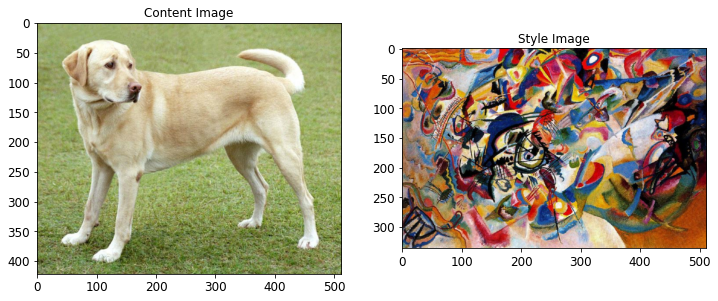

In [52]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Fast Style Transfer using TF-Hub

This tutorial demonstrates the original style-transfer algorithm, which optimizes the image content to a particular style. Before getting into the details, let's see how the [TensorFlow Hub model](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) does this:

In [ ]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## Define content and style representations

Use the intermediate layers of the model to get the *content* and *style* representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like *wheels* or *eyes*. In this case, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.


Load a [VGG19](https://keras.io/api/applications/vgg/#vgg19-function) and test run it on our image to ensure it's used correctly:

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

Now load a `VGG19` without the classification head, and list the layer names

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

Choose intermediate layers from the network to represent the style and content of the image:


In [ ]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### Intermediate layers for style and content

So why do these intermediate outputs within our pretrained image classification network allow us to define style and content representations?

At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, you're able to describe the content and style of input images.

## Build the model 

The networks in `tf.keras.applications` are designed so you can easily extract the intermediate layer values using the Keras functional API.

To define a model using the functional API, specify the inputs and outputs:

`model = Model(inputs, outputs)`

This following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [ ]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

And to create the model:

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

## Calculate style

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

This can be implemented concisely using the `tf.linalg.einsum` function:

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extract style and content


Build a model that returns the style and content tensors.

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


## Run gradient descent

With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set your style and content target values:

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Define a `tf.Variable` to contain the image to optimize. To make this quick, initialize it with the content image (the `tf.Variable` must be the same shape as the content image):

In [ ]:
image = tf.Variable(content_image)

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer. The paper recommends LBFGS, but `Adam` works okay, too:

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Use `tf.GradientTape` to update the image.

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Now run a few steps to test:

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Since it's working, perform a longer optimization:

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

## Total variation loss

One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the *total variation loss*:

In [ ]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

In [ ]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

This shows how the high frequency components have increased.

Also, this high frequency component is basically an edge-detector. You can get similar output from the Sobel edge detector, for example:

In [ ]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

The regularization loss associated with this is the sum of the squares of the values:

In [ ]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [ ]:
total_variation_loss(image).numpy()

That demonstrated what it does. But there's no need to implement it yourself, TensorFlow includes a standard implementation:

In [ ]:
tf.image.total_variation(image).numpy()

## Re-run the optimization

Choose a weight for the `total_variation_loss`:

In [ ]:
total_variation_weight=30

Now include it in the `train_step` function:

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Reinitialize the optimization variable:

In [ ]:
image = tf.Variable(content_image)

And run the optimization:

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Finally, save the result:

In [ ]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

## Learn more

This tutorial demonstrates the original style-transfer algorithm. For a simple application of style transfer check out this [tutorial](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization) to learn more about how to use the arbitrary image style transfer model from [TensorFlow Hub](https://tfhub.dev).

# Neural style transfer

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/style_transfer"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

This tutorial uses deep learning to compose one image in the style of another image (ever wish you could paint like Picasso or Van Gogh?). This is known as *neural style transfer* and the technique is outlined in <a href="https://arxiv.org/abs/1508.06576" class="external">A Neural Algorithm of Artistic Style</a> (Gatys et al.). 

Note: This tutorial demonstrates the original style-transfer algorithm. It optimizes the image content to a particular style. Modern approaches train a model to generate the stylized image directly (similar to [cyclegan](cyclegan.ipynb)). This approach is much faster (up to 1000x).

For a simple application of style transfer check out this [tutorial](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization) to learn more about how to use the pretrained [Arbitrary Image Stylization model](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) from [TensorFlow Hub](https://tfhub.dev) or how to use a style transfer model with [TensorFlow Lite](https://www.tensorflow.org/lite/models/style_transfer/overview). 

Neural style transfer is an optimization technique used to take two images—a *content* image and a *style reference* image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.

For example, let’s take an image of this dog and Wassily Kandinsky's Composition 7:

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg" width="500px"/>

[Yellow Labrador Looking](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg), from Wikimedia Commons by [Elf](https://en.wikipedia.org/wiki/User:Elf). License [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/deed.en)

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg" width="500px"/>


Now how would it look like if Kandinsky decided to paint the picture of this Dog exclusively with this style? Something like this?

<img src="https://tensorflow.org/tutorials/generative/images/stylized-image.png" style="width: 500px;"/>

## Setup


### Import and configure modules

In [ ]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Download images and choose a style image and a content image:

In [ ]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

## Visualize the input

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Create a simple function to display an image:

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Fast Style Transfer using TF-Hub

This tutorial demonstrates the original style-transfer algorithm, which optimizes the image content to a particular style. Before getting into the details, let's see how the [TensorFlow Hub model](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) does this:

In [ ]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## Define content and style representations

Use the intermediate layers of the model to get the *content* and *style* representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like *wheels* or *eyes*. In this case, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.


Load a [VGG19](https://keras.io/api/applications/vgg/#vgg19-function) and test run it on our image to ensure it's used correctly:

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

Now load a `VGG19` without the classification head, and list the layer names

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

Choose intermediate layers from the network to represent the style and content of the image:


In [ ]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### Intermediate layers for style and content

So why do these intermediate outputs within our pretrained image classification network allow us to define style and content representations?

At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, you're able to describe the content and style of input images.

## Build the model 

The networks in `tf.keras.applications` are designed so you can easily extract the intermediate layer values using the Keras functional API.

To define a model using the functional API, specify the inputs and outputs:

`model = Model(inputs, outputs)`

This following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [ ]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

And to create the model:

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

## Calculate style

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

This can be implemented concisely using the `tf.linalg.einsum` function:

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extract style and content


Build a model that returns the style and content tensors.

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


## Run gradient descent

With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set your style and content target values:

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Define a `tf.Variable` to contain the image to optimize. To make this quick, initialize it with the content image (the `tf.Variable` must be the same shape as the content image):

In [ ]:
image = tf.Variable(content_image)

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer. The paper recommends LBFGS, but `Adam` works okay, too:

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Use `tf.GradientTape` to update the image.

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Now run a few steps to test:

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Since it's working, perform a longer optimization:

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

## Total variation loss

One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the *total variation loss*:

In [ ]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

In [ ]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

This shows how the high frequency components have increased.

Also, this high frequency component is basically an edge-detector. You can get similar output from the Sobel edge detector, for example:

In [ ]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

The regularization loss associated with this is the sum of the squares of the values:

In [ ]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [ ]:
total_variation_loss(image).numpy()

That demonstrated what it does. But there's no need to implement it yourself, TensorFlow includes a standard implementation:

In [ ]:
tf.image.total_variation(image).numpy()

## Re-run the optimization

Choose a weight for the `total_variation_loss`:

In [ ]:
total_variation_weight=30

Now include it in the `train_step` function:

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Reinitialize the optimization variable:

In [ ]:
image = tf.Variable(content_image)

And run the optimization:

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Finally, save the result:

In [ ]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

## Learn more

This tutorial demonstrates the original style-transfer algorithm. For a simple application of style transfer check out this [tutorial](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization) to learn more about how to use the arbitrary image style transfer model from [TensorFlow Hub](https://tfhub.dev).